In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model, losses
import seaborn as sns

In [ ]:


def generate_synthetic_data(n_samples=100, n_genes=5, n_methylation=5, treatment_effect=0.3, random_seed=42):
    """
    Generate a synthetic dataset for training a VAE, with gene expression, methylation, and treatment status.

    Parameters:
    - n_samples: Total number of samples (half untreated, half treated)
    - n_genes: Number of gene expression features
    - n_methylation: Number of methylation features
    - treatment_effect: Magnitude of the treatment effect on gene expression and methylation
    - random_seed: Seed for reproducibility

    Returns:
    - df: A DataFrame containing gene expression, methylation, and treatment status columns
    """
    np.random.seed(random_seed)

    # Number of untreated and treated samples (split equally)
    n_untreated = n_samples // 2
    n_treated = n_samples - n_untreated

    # Generate synthetic gene expression and methylation data
    gene_expression_untreated = np.random.normal(loc=0.5, scale=0.1, size=(n_untreated, n_genes))
    gene_expression_treated = np.random.normal(loc=0.5 + treatment_effect, scale=0.1, size=(n_treated, n_genes))

    methylation_untreated = np.random.normal(loc=0.5, scale=0.1, size=(n_untreated, n_methylation))
    methylation_treated = np.random.normal(loc=0.5 - treatment_effect, scale=0.1, size=(n_treated, n_methylation))

    # Stack untreated and treated data
    gene_expression_data = np.vstack([gene_expression_untreated, gene_expression_treated])
    methylation_data = np.vstack([methylation_untreated, methylation_treated])

    # Generate binary treatment status (0 for untreated, 1 for treated)
    treatment_status = np.array([0] * n_untreated + [1] * n_treated)

    # Combine gene expression, methylation, and treatment status into a single DataFrame
    df = pd.DataFrame(np.hstack([gene_expression_data, methylation_data]),
                      columns=[f'GeneExp_{i+1}' for i in range(n_genes)] +
                              [f'Meth_{i+1}' for i in range(n_methylation)])

    df['TreatmentStatus'] = treatment_status

    return df



In [ ]:
num_genes =  1000
num_methylation = 1000
df = generate_synthetic_data(n_samples=700, n_genes=num_genes, n_methylation=num_methylation)
df.head()



,GeneExp_1,GeneExp_2,GeneExp_3,GeneExp_4,GeneExp_5,GeneExp_6,GeneExp_7,GeneExp_8,GeneExp_9,GeneExp_10,...,Meth_992,Meth_993,Meth_994,Meth_995,Meth_996,Meth_997,Meth_998,Meth_999,Meth_1000,TreatmentStatus
0,0.549671,0.486174,0.564769,0.652303,0.476585,0.476586,0.657921,0.576743,0.453053,0.554256,...,0.190450,0.472616,0.558043,0.630546,0.608547,0.627979,0.578581,0.513233,0.516460,0
1,0.639936,0.592463,0.505963,0.435306,0.569822,0.539349,0.589519,0.563517,0.604955,0.446476,...,0.588319,0.530411,0.445131,0.462346,0.402229,0.433575,0.481125,0.509365,0.622926,0
2,0.432482,0.485548,0.420758,0.469204,0.310639,0.521329,0.500121,0.418291,0.565925,0.593757,...,0.453550,0.553216,0.592727,0.390660,0.606685,0.326559,0.410587,0.517536,0.406461,0
3,0.309219,0.413961,0.458639,0.688769,0.555655,0.366452,0.548604,0.345270,0.608269,0.452888,...,0.431065,0.339414,0.515945,0.670518,0.441257,0.578745,0.518546,0.558728,0.402944,0
4,0.413651,0.496880,0.501802,0.547263,0.363314,0.559257,0.229561,0.437012,0.451173,0.563333,...,0.348344,0.455030,0.491251,0.507711,0.667372,0.337591,0.643972,0.501302,0.443936,0


In [ ]:
# 1. Data Preprocessing
# Split gene expression, methylation, and treatment status
X_expression = df.iloc[:, :num_genes].values
X_methylation = df.iloc[:, num_genes:num_genes + num_methylation].values
y_treatment = df['TreatmentStatus'].values

# Normalize the gene expression and methylation data (Min-Max Scaling)
from sklearn.preprocessing import MinMaxScaler
scaler_expression = MinMaxScaler()
scaler_methylation = MinMaxScaler()

X_expression_scaled = scaler_expression.fit_transform(X_expression)
X_methylation_scaled = scaler_methylation.fit_transform(X_methylation)

# Combine scaled features into a single input matrix
X_scaled = np.hstack([X_expression_scaled, X_methylation_scaled])

In [ ]:
# Split data into train/test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_treatment, test_size=0.2, random_state=42)


In [ ]:
# 2. Build the Compositional Autoencoder Model
class CompositionalAutoencoder(Model):
    def __init__(self, input_dim, latent_dim, treatment_dim):
        super(CompositionalAutoencoder, self).__init__()
        # Encoder network
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(input_dim,)),
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(latent_dim, activation='relu')  # Latent space
        ])

        # Treatment effect function applied to latent space
        self.treatment_function = tf.keras.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(treatment_dim, activation='relu'),
            layers.Dense(latent_dim, activation='relu')  # Adjust latent space for treatment
        ])

        # Decoder network
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(64, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(input_dim, activation='sigmoid')  # Reconstruct input features (expression + methylation)
        ])

    def call(self, inputs):
        # Inputs consist of features and treatment status
        X, treatment = inputs
        # Encode the input data
        latent_basal = self.encoder(X)

        # Apply the treatment function (compositional effect) based on treatment status
        treatment_effect = self.treatment_function(latent_basal)

        # Reshape treatment to be compatible with treatment_effect
        treatment = tf.reshape(treatment, [-1, 1])

        # Cast treatment to float32 to match the type of treatment_effect
        treatment = tf.cast(treatment, dtype=tf.float32)

        # Combine basal and treatment effect in the latent space
        latent_combined = latent_basal + treatment * treatment_effect

        # Decode back to the original input space (predict treated or untreated states)
        decoded_output = self.decoder(latent_combined)
        return decoded_output

In [ ]:
# 3. Training the Autoencoder

# Hyperparameters
input_dim = X_train.shape[1]  # Number of features (expression + methylation)
latent_dim = 32  # Dimensionality of the latent space
treatment_dim = 16  # Size of the treatment adjustment

# Create an instance of the autoencoder model
autoencoder = CompositionalAutoencoder(input_dim=input_dim, latent_dim=latent_dim, treatment_dim=treatment_dim)

# Compile the model with an optimizer and loss function
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

# Train the model
history = autoencoder.fit((X_train, y_train), X_train, epochs=50, batch_size=32, validation_data=((X_test, y_test), X_test))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0397 - val_loss: 0.0234
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0175 - val_loss: 0.0133
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0131 - val_loss: 0.0130
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0128 - val_loss: 0.0129
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0128 - val_loss: 0.0129
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0128 - val_loss: 0.0129
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0129 - val_loss: 0.0129
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0128 - val_loss: 0.0129
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0129 - val_loss: 0.0129
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0128 - val_loss: 0.0129
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0128 - val_loss: 0.0129
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0

In [ ]:
# 4. Evaluation
# Evaluate on test data
test_loss = autoencoder.evaluate((X_test, y_test), X_test)
print(f"Test Loss: {test_loss}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0129 
Test Loss: 0.012897983193397522


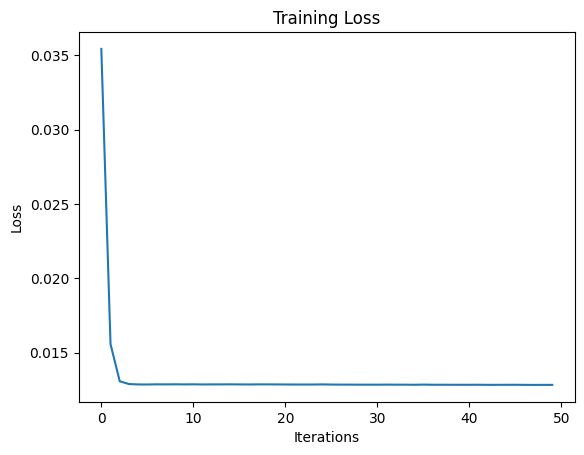

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

In [ ]:
# For example, predict treated states based on new basal data
predicted_treated = autoencoder.predict((X_test, np.ones(X_test.shape[0])))  # Treat as treated samples

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [ ]:
X_test[:, 0]


array([0.23503965, 0.27954076, 0.05579662, 0.59306174, 0.71693716,
       0.57589955, 0.35467752, 0.44032328, 0.67294545, 0.42485984,
       0.17895819, 0.7124045 , 0.69343523, 0.09732004, 0.82937628,
       0.68855764, 0.36663158, 0.57788964, 0.33742302, 0.19640116,
       0.50074318, 0.40409787, 0.40845687, 0.45067445, 0.46965058,
       0.30660965, 0.2613055 , 0.        , 0.73010081, 0.64482917,
       0.3902255 , 0.33620402, 0.35787021, 0.1900237 , 0.82921027,
       0.57882543, 0.50367072, 0.7362429 , 0.75928268, 0.26482465])

In [ ]:
predicted_treated[:,0].shape

(40,)

<Axes: >

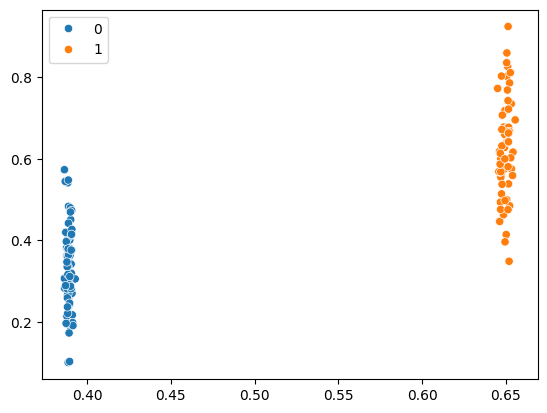

In [ ]:
sns.scatterplot(x = predicted_treated[:,1], y = X_test[:,1], hue = y_test)

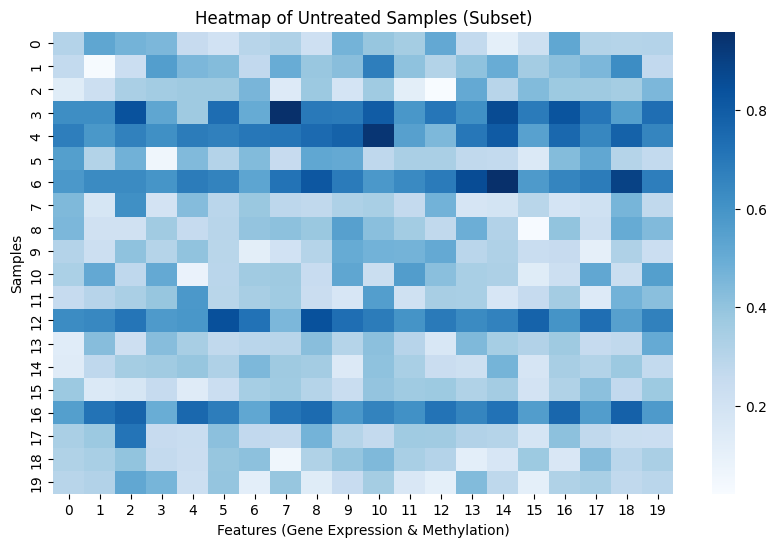

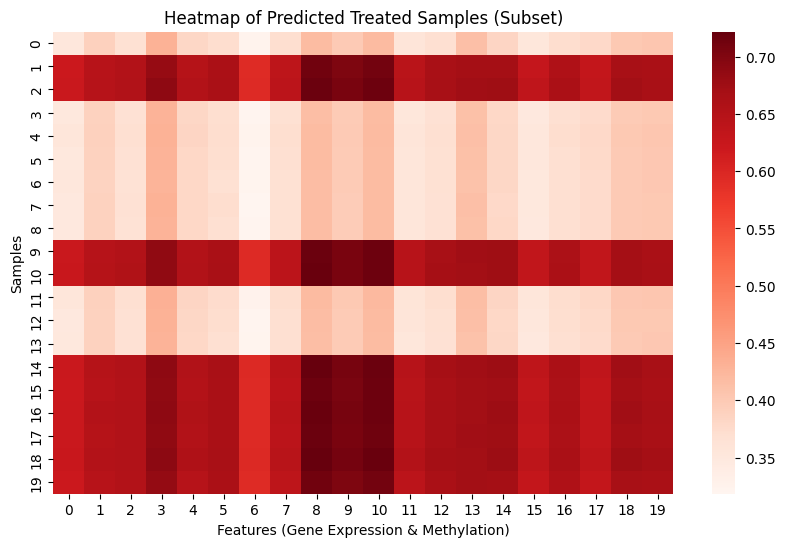

In [ ]:
# Let's visualize the first 20 samples and genes/methylation features
num_samples_to_visualize = 20
num_features_to_visualize = 20

# Subset the untreated and predicted treated data
untreated_subset = X_train[:num_samples_to_visualize, :num_features_to_visualize]
treated_subset = predicted_treated[:num_samples_to_visualize, :num_features_to_visualize]

# Create a heatmap for untreated samples
plt.figure(figsize=(10, 6))
sns.heatmap(untreated_subset, cmap="Blues", annot=False)
plt.title("Heatmap of Untreated Samples (Subset)")
plt.xlabel("Features (Gene Expression & Methylation)")
plt.ylabel("Samples")
plt.show()

# Create a heatmap for predicted treated samples
plt.figure(figsize=(10, 6))
sns.heatmap(treated_subset, cmap="Reds", annot=False)
plt.title("Heatmap of Predicted Treated Samples (Subset)")
plt.xlabel("Features (Gene Expression & Methylation)")
plt.ylabel("Samples")
plt.show()


<Axes: >

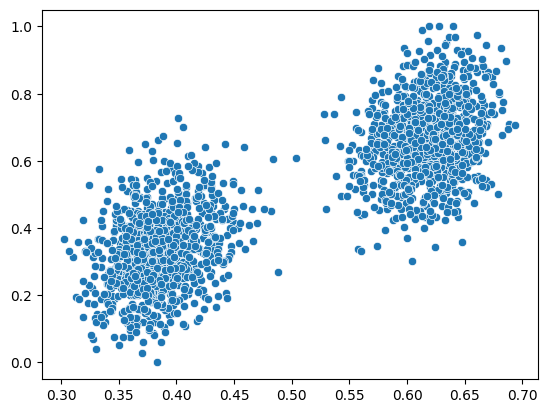

In [ ]:
sns.scatterplot(x = predicted_treated[0], y = X_test[0])